##  Stereo Disparity Project

In [173]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import tensorflow as tf
from scipy import signal



In [174]:
root_path = ''
image_left= cv2.imread(os.path.join(root_path, "2018-07-09-16-11-56_2018-07-09-16-11-56-702-left.jpg"),cv2.IMREAD_GRAYSCALE).astype(np.float32)
image_right= cv2.imread(os.path.join(root_path, "2018-07-09-16-11-56_2018-07-09-16-11-56-702-right.jpg"),cv2.IMREAD_GRAYSCALE).astype(np.float32)
gt_disparity = cv2.imread(os.path.join(root_path, "2018-07-09-16-11-56_2018-07-09-16-11-56-702-disparity.png"),-1).astype(np.float32)/256

bsize = (3, 3)
image_left_blur = cv2.GaussianBlur(image_left, bsize, 0, 0)
image_right_blur = cv2.GaussianBlur(image_right, bsize, 0, 0)

In [175]:
def normalise(image):
    h,l=image.shape
    average=np.sum(image)/(h*l)
    return (image-average)/average

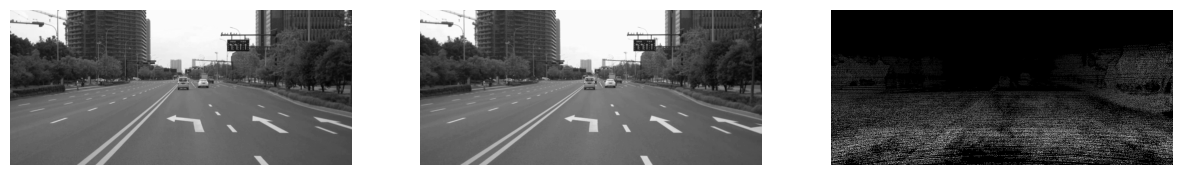

In [176]:
plt.subplots(figsize = (15,15))
plt.subplot(1,3,1)
plt.imshow(image_left,cmap = 'gray')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(image_right,cmap = 'gray')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(gt_disparity,cmap = 'gray')
plt.axis('off')
plt.show()

## Basci stereo block matching with SAD,SSD and NCC

In [177]:
def BM_disparity(BLOCK_SIZE,image_left,image_right,search_length,similarity_metric):
    padding_size = math.floor(BLOCK_SIZE/2)
    image_left_padded = cv2.copyMakeBorder(src=image_left, top=padding_size, bottom=padding_size, left=padding_size, right=padding_size, borderType=cv2.BORDER_CONSTANT) 
    image_right_padded = cv2.copyMakeBorder(src=image_right, top=padding_size, bottom=padding_size, left=padding_size, right=padding_size, borderType=cv2.BORDER_CONSTANT) 
    rows, cols = image_left.shape
    disparity_image = np.zeros((rows,cols))
    for row_left in tqdm(range(image_left.shape[0])):
        for column_left in range(image_left.shape[1]):
            left_window= image_left_padded[row_left:row_left+BLOCK_SIZE,column_left:column_left+BLOCK_SIZE]
            metric_per_row= []
            for column_right in range(column_left - search_length,column_left):
                if column_left - search_length <= 0:
                    column_right = 0  
                right_window = image_right_padded[row_left:row_left+BLOCK_SIZE,column_right:column_right+BLOCK_SIZE]
                if similarity_metric == 'SSD':
                    metric_per_column = np.sum((left_window - right_window)**2)
                    metric_per_row.append([metric_per_column,column_right])
                elif similarity_metric == 'SAD':
                    metric_per_column = np.sum(abs(left_window - right_window))
                    metric_per_row.append([metric_per_column,column_right])
                #The image patch needs to be normalized first
                elif similarity_metric == 'NCC':
                    sum_windows = np.sum(left_window*right_window)
                    left_norm = np.linalg.norm(left_window)
                    right_norm = np.linalg.norm(right_window)
                    metric_per_column = sum_windows / (left_norm*right_norm)
                    metric_per_row.append([metric_per_column,column_right])
                # elif similarity_metric == 'RMS':
                #     metric_per_column = np.sqrt(np.sum(((left_window - right_window)**2))/left_window.shape[0])
                #     metric_per_row.append([metric_per_column,column_right])
            if similarity_metric == 'NCC':
                metric_per_row.sort(key = lambda x: x[0],reverse= True)
                disparity_image[row_left][column_left] = np.abs(column_left - metric_per_row[0][1])
            else:
                metric_per_row.sort(key = lambda x: x[0])
                disparity_image[row_left][column_left] = np.abs(column_left - metric_per_row[0][1])
    return disparity_image

def rms_error(disparity_image,gt_disparity):
    rms_non_divide = np.sum(np.square(disparity_image - gt_disparity))
    non_zeros = np.count_nonzero(gt_disparity)
    zeros = np.count_nonzero(gt_disparity == 0)
    total_rms = math.sqrt(rms_non_divide/non_zeros)
    image_error = np.abs(disparity_image - gt_disparity)
    fraction_four = (np.count_nonzero(image_error < 4)- zeros) / non_zeros
    fraction_two = (np.count_nonzero(image_error < 2)- zeros) / non_zeros
    fraction_one = (np.count_nonzero(image_error < 1)- zeros) / non_zeros
    fraction_05 = (np.count_nonzero(image_error < 0.5)- zeros) / non_zeros
    fraction_025 = (np.count_nonzero(image_error < 0.25)- zeros) / non_zeros
    return total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025

def same_mask_as_gt(disparity_image,gt_disparity):
    # same mask
    zero=np.where(gt_disparity==0)
    disparity_image[zero]=0
    return disparity_image

In [178]:
BLOCK_SIZE = 19
SEARCH_LENGTH = 70

## SSD

100%|██████████| 400/400 [01:22<00:00,  4.83it/s]


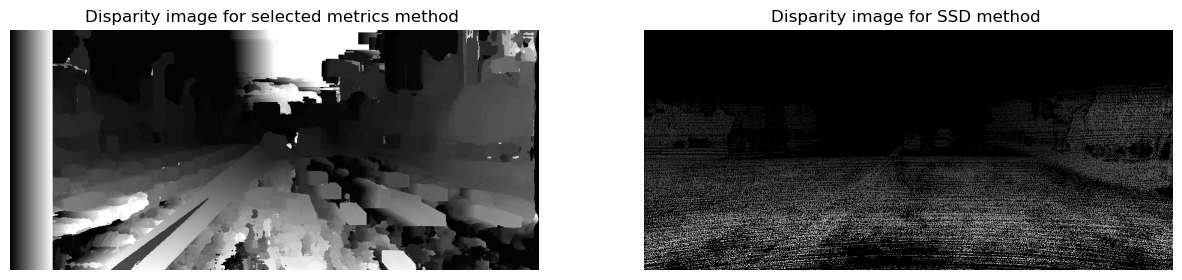

total_rms 17.678659121296
fraction_four 0.6360593994259719
fraction_two 0.5090358370486335
fraction_one 0.3555797570023483
fraction 0.5 0.21117653064697273
fraction 0.25 0.11566778976505689
CPU times: user 1min 22s, sys: 411 ms, total: 1min 22s
Wall time: 1min 22s


In [180]:
%%time
similarity_metric = 'SSD'

disparity_image = BM_disparity(BLOCK_SIZE,image_left,image_right,SEARCH_LENGTH,similarity_metric)

plt.subplots(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(disparity_image,cmap = 'gray')
plt.title('Disparity image for selected metrics method ')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(gt_disparity,cmap = 'gray')
plt.title('Disparity image for SSD method ')
plt.axis('off')
plt.show()


disparity_image = same_mask_as_gt(disparity_image,gt_disparity)
total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(disparity_image,gt_disparity)
print('total_rms',total_rms)
print('fraction_four',fraction_four)
print('fraction_two',fraction_two)
print('fraction_one',fraction_one)
print('fraction 0.5',fraction_05)
print('fraction 0.25',fraction_025)  

## SAD

100%|██████████| 400/400 [01:22<00:00,  4.82it/s]


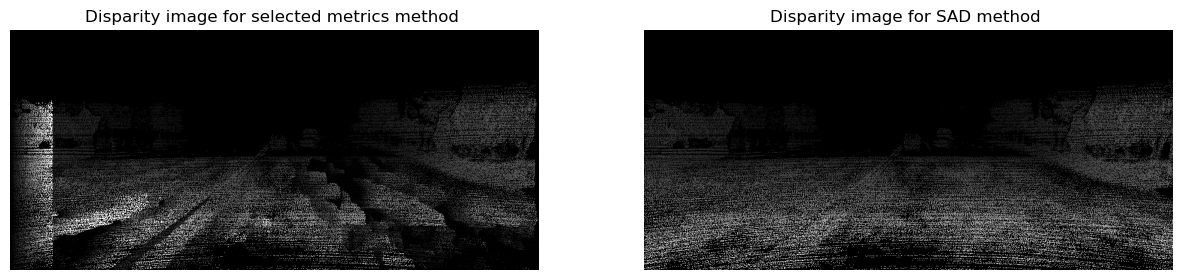

total_rms 17.819790500756525
fraction_four 0.6257586586348115
fraction_two 0.5131765533358291
fraction_one 0.3686031605576921
fraction 0.5 0.22405245663592327
fraction 0.25 0.12392653348307979


In [181]:
similarity_metric = 'SAD'
disparity_image = BM_disparity(BLOCK_SIZE,image_left,image_right,SEARCH_LENGTH,similarity_metric)

zero=np.where(gt_disparity==0)
disparity_image[zero]=0
plt.subplots(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(disparity_image,cmap = 'gray')
plt.title('Disparity image for selected metrics method ')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(gt_disparity,cmap = 'gray')
plt.title('Disparity image for SAD method ')
plt.axis('off')
plt.show()

total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(disparity_image,gt_disparity)
print('total_rms',total_rms)
print('fraction_four',fraction_four)
print('fraction_two',fraction_two)
print('fraction_one',fraction_one)
print('fraction 0.5',fraction_05)
print('fraction 0.25',fraction_025)  

## NCC

100%|██████████| 400/400 [02:45<00:00,  2.41it/s]


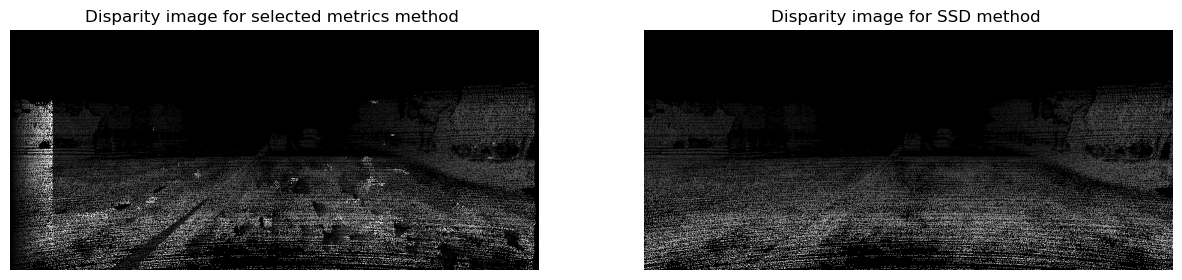

total_rms 13.152245515384914
fraction_four 0.764569081895427
fraction_two 0.6009483941961905
fraction_one 0.40689060567902074
fraction 0.5 0.2407854882074669
fraction 0.25 0.13114158980816573
CPU times: user 2min 45s, sys: 831 ms, total: 2min 46s
Wall time: 2min 45s


In [182]:
%%time
similarity_metric = 'NCC'
disparity_image = BM_disparity(BLOCK_SIZE,image_left,image_right,SEARCH_LENGTH,similarity_metric)
# bsize = (3, 3)
# disparity_image_blur = cv2.GaussianBlur(disparity_image, bsize,0)
# disparity_image_blur = cv2.medianBlur(disparity_image,5)
disparity_image = same_mask_as_gt(disparity_image,gt_disparity)

# disparity_image = same_mask_as_gt(disparity_image_blur,gt_disparity)
plt.subplots(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(disparity_image,cmap = 'gray')
plt.title('Disparity image for selected metrics method ')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(gt_disparity,cmap = 'gray')
plt.title('Disparity image for SSD method ')
plt.axis('off')
plt.show()
total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(disparity_image,gt_disparity)
print('total_rms',total_rms)
print('fraction_four',fraction_four)
print('fraction_two',fraction_two)
print('fraction_one',fraction_one)
print('fraction 0.5',fraction_05)
print('fraction 0.25',fraction_025)  

# Utilizing kernel doing the convolution

In [9]:
def SAD_conv(kernel,window_size,image_left,image_right):
    row,column = image_left.shape
    disparity_3d=np.zeros((window_size,row,column))
    for i in range(window_size):
        newimage_right=cv2.copyMakeBorder(image_right[:,:column-i],0,0,i,0,cv2.BORDER_REFLECT)
        disparity_3d[i]=cv2.filter2D(np.abs(image_left-newimage_right),-1,kernel)
    min_disparity=np.argmin(disparity_3d,axis=0)
    return min_disparity

def SSD_conv(kernel,window_size,image_left,image_right):
    row,column = image_left.shape
    disparity_3d=np.zeros((window_size,row,column))
    for i in range(window_size):
        newimage_right=cv2.copyMakeBorder(image_right[:,:column-i],0,0,i,0,cv2.BORDER_REFLECT)
        disparity_3d[i]=cv2.filter2D((image_left-newimage_right)**2,-1,kernel)
    min_disparity=np.argmin(disparity_3d,axis=0)
    return min_disparity

def NCC_conv(kernel,window_size,image_left,image_right):
    row,column = image_left.shape
    disparity_3d=np.zeros((window_size,row,column))
    for i in range(window_size):
        # newimage_right=np.roll(image_right,i)
        # newimage_right[:,:i]=image_right[:,:i]
        newimage_right=cv2.copyMakeBorder(image_right[:,:column-i],0,0,i,0,cv2.BORDER_REFLECT)
        disparity_up=image_left*newimage_right
        disparity_down_left=image_left**2
        disparity_down_right=newimage_right**2
        conv_disparity_up=cv2.filter2D(disparity_up,-1,kernel)
        conv_disparity_down_left=cv2.filter2D(disparity_down_left,-1,kernel)
        conv_disparity_down_right=cv2.filter2D(disparity_down_right,-1,kernel)
        conv_disparity=conv_disparity_up/np.sqrt(conv_disparity_down_left*conv_disparity_down_right)
        disparity_3d[i]=conv_disparity
        
    min_disparity=np.argmax(disparity_3d,axis=0)
    return min_disparity

In [196]:
%%time
kernel = np.ones((19,19)).astype(np.float32)
window_size=70
# norm_image_left=normalise(image_left)
# norm_image_right=normalise(image_right)
disparity_image = SSD_conv(kernel,window_size,image_left,image_right)
zero=np.where(gt_disparity==0)
disparity_image[zero]=0
# plt.subplots(figsize = (15,15))
# plt.subplot(1,2,1)
# plt.imshow(disparity_image,cmap = 'gray')
# plt.title('Disparity image for selected metrics method ')
# plt.axis('off')
# plt.subplot(1,2,2)
# plt.imshow(gt_disparity,cmap = 'gray')
# plt.title('Disparity image for SAD method ')
# plt.axis('off')
# plt.show()
total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(disparity_image,gt_disparity)
print('total_rms',total_rms)
print('fraction_four',fraction_four)
print('fraction_two',fraction_two)
print('fraction_one',fraction_one)
print('fraction 0.5',fraction_05)
print('fraction 0.25',fraction_025)

total_rms 16.157957976273806
fraction_four 0.6905353435660075
fraction_two 0.562093727665657
fraction_one 0.39915370565746633
fraction 0.5 0.23792669230507435
fraction 0.25 0.1290655594504759
CPU times: user 425 ms, sys: 76 ms, total: 501 ms
Wall time: 511 ms


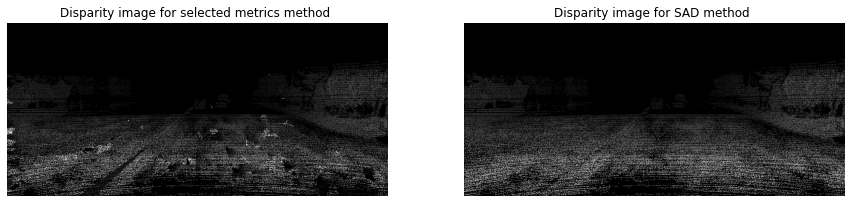

total_rms 10.174535392780381
fraction_four 0.8434468910594561
fraction_two 0.6607221862981997
fraction_one 0.4498746440685657
fraction 0.5 0.26538020851059
fraction 0.25 0.14213434071855607


In [178]:
# apply kernel NCC
kernel = np.ones((21,21)).astype(np.float32)
window_size=80
# image_left=normalise(image_left)
# image_right=normalise(image_right)
disparity_image = NCC_conv(kernel,window_size,image_left,image_right)
zero=np.where(gt_disparity==0)
disparity_image[zero]=0
plt.subplots(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(disparity_image,cmap = 'gray')
plt.title('Disparity image for selected metrics method ')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(gt_disparity,cmap = 'gray')
plt.title('Disparity image for SAD method ')
plt.axis('off')
plt.show()
total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(disparity_image,gt_disparity)
print('total_rms',total_rms)
print('fraction_four',fraction_four)
print('fraction_two',fraction_two)
print('fraction_one',fraction_one)
print('fraction 0.5',fraction_05)
print('fraction 0.25',fraction_025)  

In [180]:
kernel = np.ones((21,21)).astype(np.float32)
window_size=80
disparity_image = NCC_conv(kernel,window_size,image_left,image_right)
median_smooth_disparity_image=signal.medfilt(disparity_image, kernel_size=7)


total_rms 9.263870752692522
fraction_four 0.8595786679372426
fraction_two 0.6759577533494424
fraction_one 0.45986908529875553
fraction 0.5 0.27087091175169314
fraction 0.25 0.144108271222589


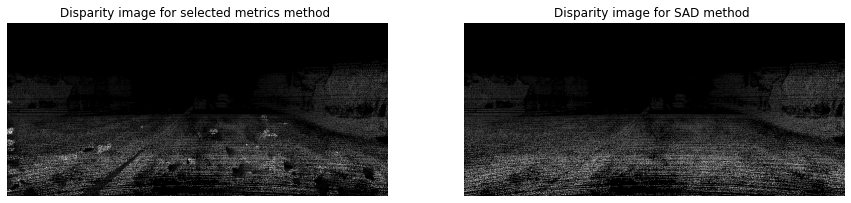

In [181]:
#smoothing with median blur
zero=np.where(gt_disparity==0)
median_smooth_disparity_image[zero]=0
total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(median_smooth_disparity_image,gt_disparity)
print('total_rms',total_rms)
print('fraction_four',fraction_four)
print('fraction_two',fraction_two)
print('fraction_one',fraction_one)
print('fraction 0.5',fraction_05)
print('fraction 0.25',fraction_025)  

plt.subplots(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(median_smooth_disparity_image,cmap = 'gray')
plt.title('Disparity image for selected metrics method ')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(gt_disparity,cmap = 'gray')
plt.title('Disparity image for SAD method ')
plt.axis('off')
plt.show()

In [182]:
#smoothing with gaussian blur
disparity_image=np.float32(disparity_image)
gau_smooth_disparity_image= cv2.GaussianBlur(disparity_image,(7,7),0)
zero=np.where(gt_disparity==0)
gau_smooth_disparity_image[zero]=0
total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(gau_smooth_disparity_image,gt_disparity)
print('total_rms',total_rms)
print('fraction_four',fraction_four)
print('fraction_two',fraction_two)
print('fraction_one',fraction_one)
print('fraction 0.5',fraction_05)
print('fraction 0.25',fraction_025) 

total_rms 8.76038027459116
fraction_four 0.830491554073217
fraction_two 0.6638305596206423
fraction_one 0.4585531316294002
fraction 0.5 0.2772237915347877
fraction 0.25 0.15221953737421864


In [183]:
bi_smooth_disparity_image = cv2.bilateralFilter(disparity_image,9,75,75)
zero=np.where(gt_disparity==0)
bi_smooth_disparity_image[zero]=0
total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(bi_smooth_disparity_image,gt_disparity)
print('total_rms',total_rms)
print('fraction_four',fraction_four)
print('fraction_two',fraction_two)
print('fraction_one',fraction_one)
print('fraction 0.5',fraction_05)
print('fraction 0.25',fraction_025)

total_rms 8.365894479986007
fraction_four 0.8266798262033602
fraction_two 0.6685271528888587
fraction_one 0.4630001474775664
fraction 0.5 0.28046829799543954
fraction 0.25 0.15530522184029313


In [168]:
# find best Search window size and kernel window size for sad
data=[]
for search_window_size in tqdm(range(1,120)):
    for kernel_size in range(1,50,2):
        kernel = np.ones((kernel_size,kernel_size)).astype(np.float32)
        window_size=search_window_size
        disparity_image = SSD_conv(kernel,window_size,image_left,image_right)
        zero=np.where(gt_disparity==0)
        disparity_image[zero]=0
        total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(disparity_image,gt_disparity)
        data.append((search_window_size,kernel_size,fraction_four))

100%|██████████| 119/119 [16:58<00:00,  8.56s/it]


In [171]:
ssd_data = np.array([list(i) for i in data])

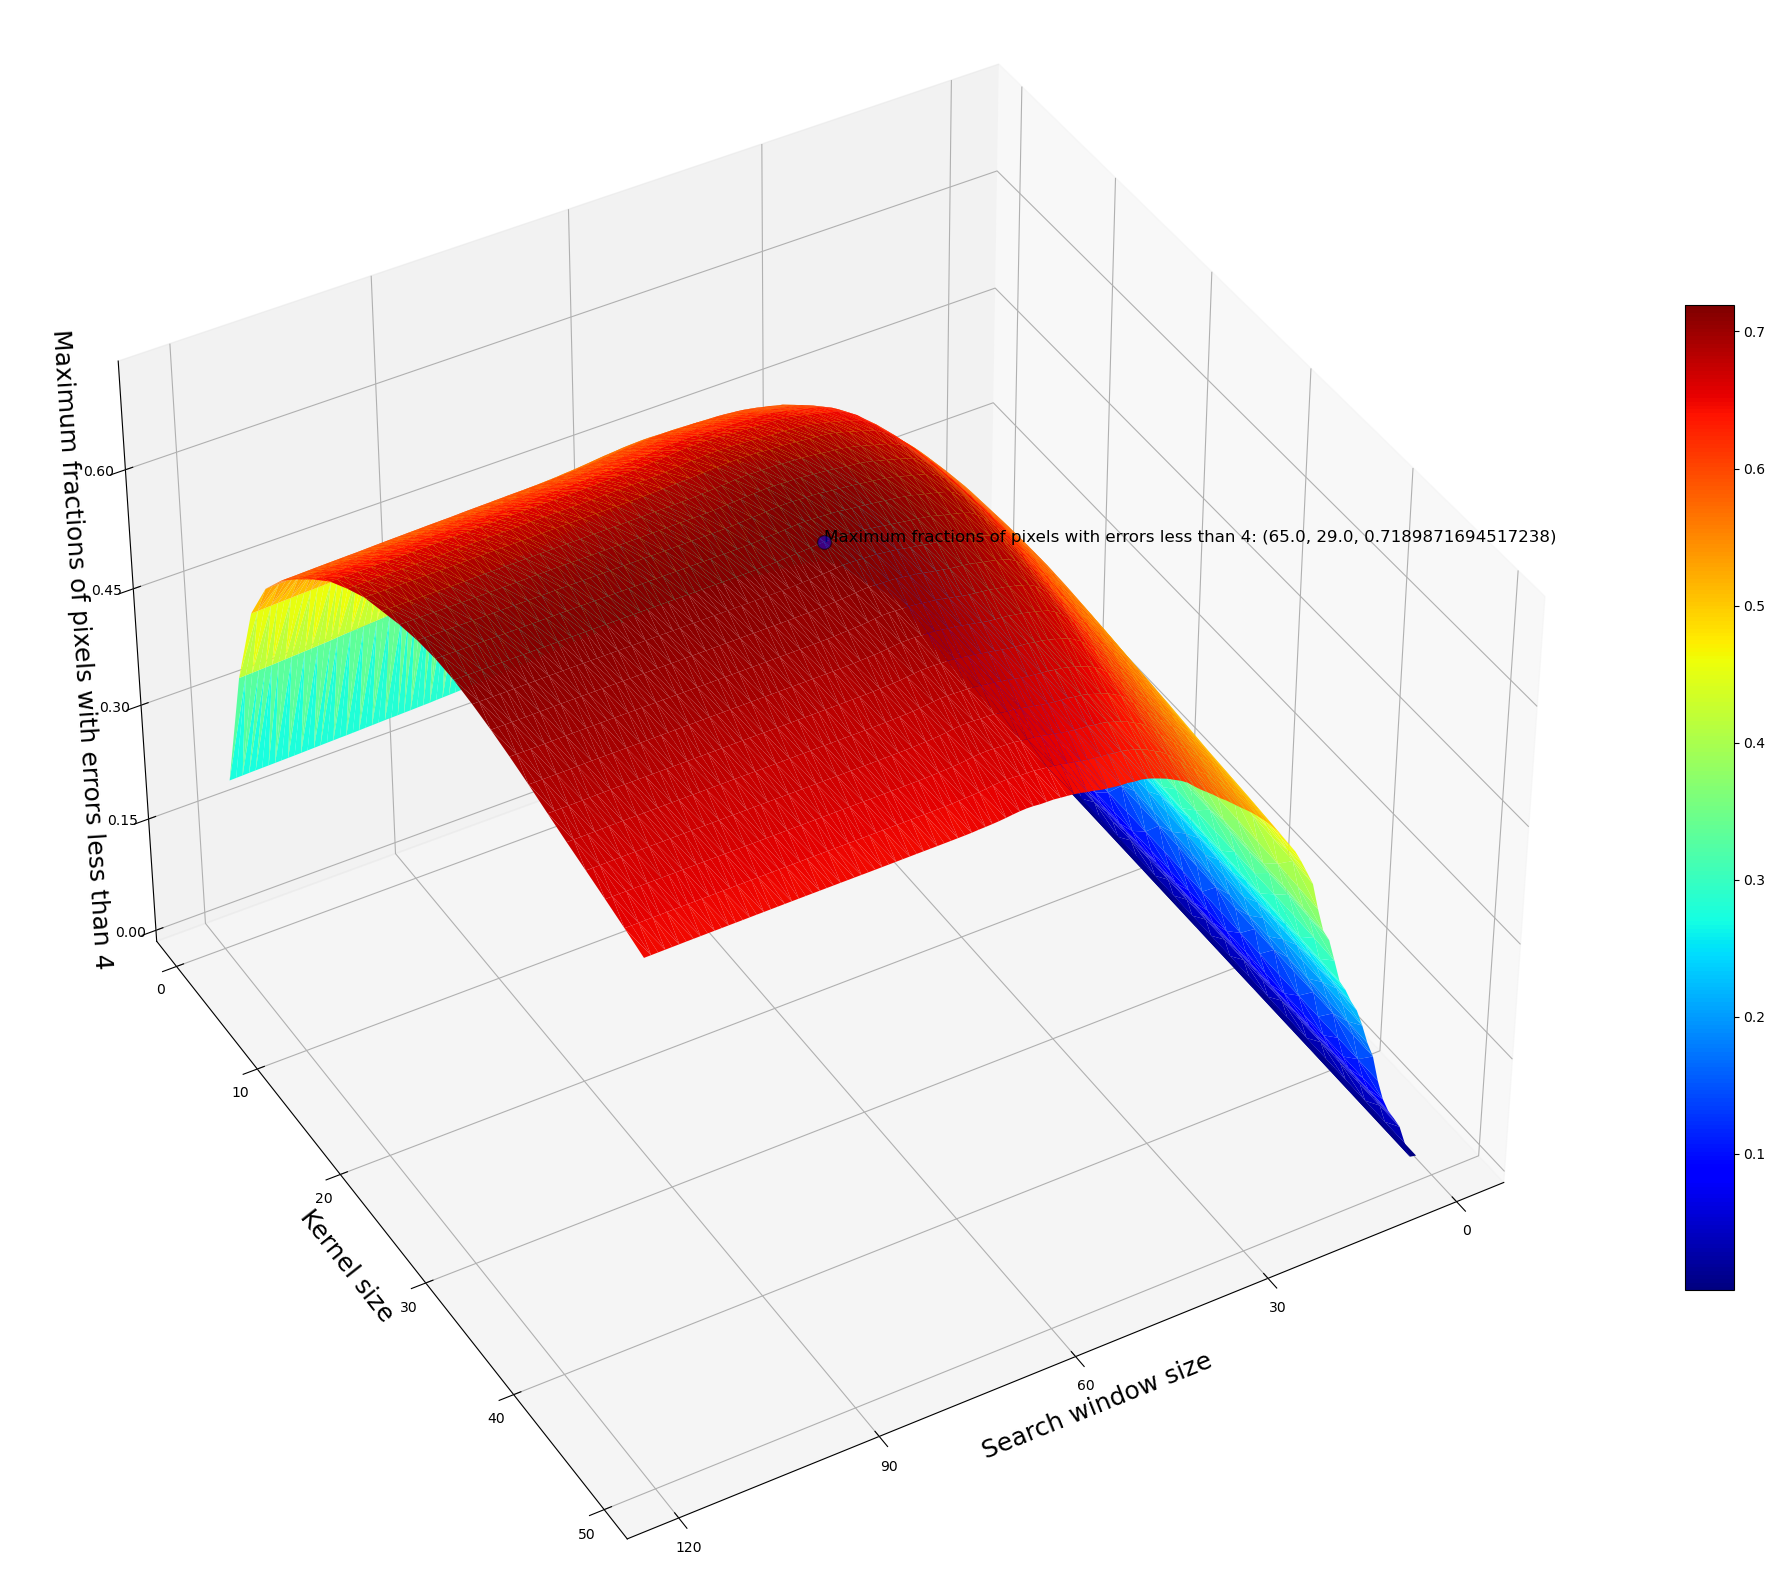

In [172]:
import sys

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import numpy
from numpy.random import randn
from scipy import array, newaxis



Xs = ssd_data[:,0]
Ys = ssd_data[:,1]
Zs = ssd_data[:,2]


# ======
## plot:

fig = plt.figure(figsize= (20,20))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(Xs, Ys, Zs, cmap=cm.jet, linewidth=0,zorder=0)
fig.colorbar(surf,shrink = 0.5)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.set_xlabel('Search window size',fontsize=18)
ax.set_ylabel('Kernel size',fontsize=18)
ax.set_zlabel('Maximum fractions of pixels with errors less than 4',fontsize=18)
fig.tight_layout()


# calc index of min/max Z value
xmin, ymin = Xs[np.argmax(Zs)],Ys[np.argmax(Zs)]


# min max points in 3D space (x,y,z)
mi = (xmin, ymin, Zs.max())
#plot points.
ax.plot(xmin,ymin,Zs.max(),"bo",markersize=10,markeredgecolor="black",alpha = 0.5,zorder=10)
ax.text(xmin,ymin,Zs.max(),f'Maximum fractions of pixels with errors less than 4: {mi}',size=12,color ='black')
ax.legend
ax.view_init(40, 60)
plt.show()
fig.savefig('ssd_3D.png')

In [154]:
# find best Search window size and kernel window size for sad
data=[]
for search_window_size in tqdm(range(1,120)):
    for kernel_size in range(1,50,2):
        kernel = np.ones((kernel_size,kernel_size)).astype(np.float32)
        window_size=search_window_size
        disparity_image = NCC_conv(kernel,window_size,image_left,image_right)
        zero=np.where(gt_disparity==0)
        disparity_image[zero]=0
        total_rms,fraction_four,fraction_two,fraction_one,fraction_05,fraction_025 = rms_error(disparity_image,gt_disparity)
        data.append((search_window_size,kernel_size,fraction_four))

100%|██████████| 119/119 [46:19<00:00, 23.36s/it]


In [158]:
data

[(1, 1, 0.0),
 (1, 3, 0.0),
 (1, 5, 0.0),
 (1, 7, 0.0),
 (1, 9, 0.0),
 (1, 11, 0.0),
 (1, 13, 0.0),
 (1, 15, 0.0),
 (1, 17, 0.0),
 (1, 19, 0.0),
 (1, 21, 0.0),
 (1, 23, 0.0),
 (1, 25, 0.0),
 (1, 27, 0.0),
 (1, 29, 0.0),
 (1, 31, 0.0),
 (1, 33, 0.0),
 (1, 35, 0.0),
 (1, 37, 0.0),
 (1, 39, 0.0),
 (1, 41, 0.0),
 (1, 43, 0.0),
 (1, 45, 0.0),
 (1, 47, 0.0),
 (1, 49, 0.0),
 (2, 1, 0.0),
 (2, 3, 0.0010663762493051537),
 (2, 5, 0.0011117539620415433),
 (2, 7, 0.0012138538156984198),
 (2, 9, 0.0014067090948280752),
 (2, 11, 0.0014067090948280752),
 (2, 13, 0.0014407423793803672),
 (2, 15, 0.0014974645203008543),
 (2, 17, 0.0014974645203008543),
 (2, 19, 0.0015655310894054386),
 (2, 21, 0.0015655310894054386),
 (2, 23, 0.0015088089484849515),
 (2, 25, 0.0015314978048531463),
 (2, 27, 0.0015655310894054386),
 (2, 29, 0.001610908802141828),
 (2, 31, 0.0015882199457736333),
 (2, 33, 0.0017470419403509967),
 (2, 35, 0.0017810752249032887),
 (2, 37, 0.001815108509455581),
 (2, 39, 0.00188317507856016

In [162]:
reformated_data = np.array([list(i)for i in data])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


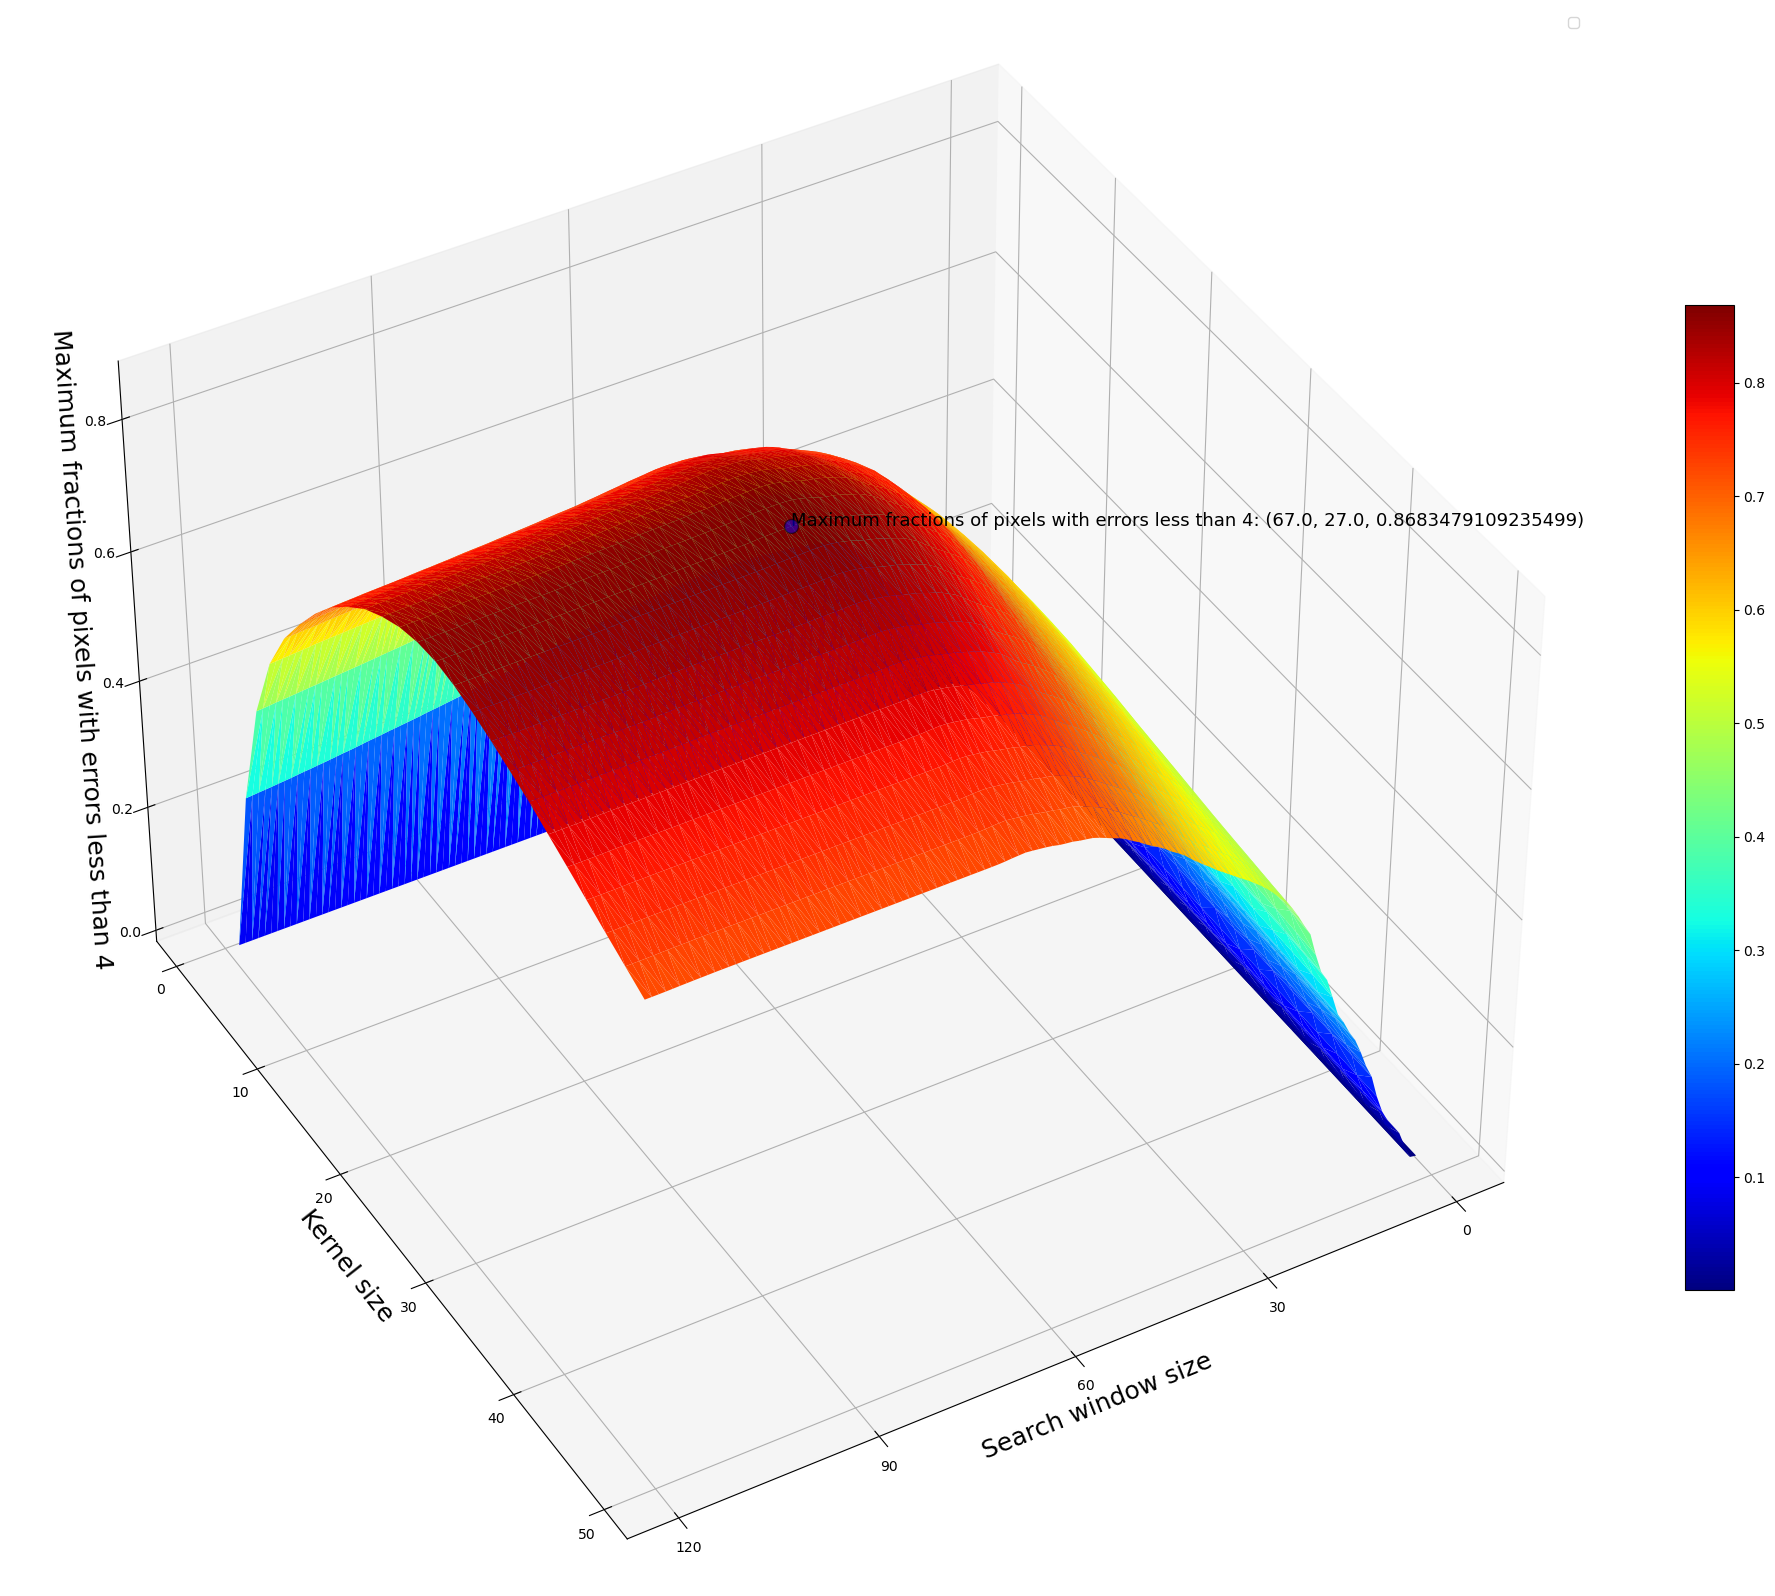

In [167]:

Xs = reformated_data[:,0]
Ys = reformated_data[:,1]
Zs = reformated_data[:,2]


# ======
## plot:

fig = plt.figure(figsize= (20,20))
ax = fig.add_subplot(projection='3d')

# calc index of min/max Z value
xmin, ymin = Xs[np.argmax(Zs)],Ys[np.argmax(Zs)]


# min max points in 3D space (x,y,z)
mi = (xmin, ymin, Zs.max())
#plot points.
ax.plot(xmin,ymin,Zs.max(),"bo",markersize=10,markeredgecolor="black",alpha = 0.5,zorder=10)
# ax.scatter(xmin,ymin,Zs.min(),color="k",s=20)
ax.text(xmin,ymin,Zs.max(),f'Maximum fractions of pixels with errors less than 4: {mi}',size=13,color ='black')
surf = ax.plot_trisurf(Xs, Ys, Zs, cmap=cm.jet, linewidth=0,zorder=0)
fig.colorbar(surf,shrink = 0.5)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.set_xlabel('Search window size',fontsize=18)
ax.set_ylabel('Kernel size',fontsize=18)
ax.set_zlabel('Maximum fractions of pixels with errors less than 4',fontsize=18)
fig.tight_layout()


ax.legend()
ax.view_init(40, 60)
plt.show()

fig.savefig('ncc_3D.png')